In [74]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'

import warnings
warnings.filterwarnings('ignore')

In [75]:
random_value = 42
random.seed(random_value)
np.random.seed(random_value)

In [76]:
class CreateSampleDataset():
    def __init__(self, n_teachers=1000, school_teacher_ratio=1.05, teacher_per_school=15.,
                 std_dev_teacher_per_school=3., min_teachers_per_school=5, p_rural=0.3, p_car=0.7, p_experienced=0.7):
        self.n_teachers = n_teachers
        self.n_schools = int(n_teachers * school_teacher_ratio / teacher_per_school)
        self.teacher_per_school = teacher_per_school
        self.std_dev_teacher_per_school = std_dev_teacher_per_school
        self.min_teachers_per_school = min_teachers_per_school
        self.p_rural = p_rural
        self.p_car = p_car
        self.p_experienced = p_experienced

    def _createTeachers(self):
        x_location = np.random.uniform(0., 1., self.n_teachers)
        y_location = np.random.uniform(0., 1., self.n_teachers)
        rural = np.random.choice([0, 1], p=[1 - self.p_rural, self.p_rural], size=self.n_teachers)
        car = np.random.choice([0, 1], p=[1 - self.p_car, self.p_car], size=self.n_teachers)
        experienced = np.random.choice([0, 1], p=[1 - self.p_experienced, self.p_experienced], size=self.n_teachers)
        teachers = {'ID': range(self.n_teachers),
                    'x_location': x_location,
                    'y_location': y_location,
                    'rural': rural,
                    'car': car,
                    'experience': experienced,
                    }

        return teachers

    def _createSchools(self):
        x_location = np.random.uniform(0., 1., self.n_schools)
        y_location = np.random.uniform(0., 1., self.n_schools)
        rural = np.random.choice([0, 1], p=[1 - self.p_rural, self.p_rural], size=self.n_schools)
        n_teachers = np.random.normal(loc=self.teacher_per_school, scale=self.std_dev_teacher_per_school, size=self.n_schools).astype(int)
        n_teachers_clipped = np.clip(n_teachers, a_min=self.min_teachers_per_school, a_max=None, out=n_teachers)
        schools = {'ID': range(self.n_schools),
                   'x_location': x_location,
                   'y_location': y_location,
                   'rural': rural,
                   'n_teachers': n_teachers_clipped,
                   }

        return schools

    def make_dataset(self):
        teachers = pd.DataFrame(self._createTeachers())
        schools = pd.DataFrame(self._createSchools())

        return teachers, schools

In [77]:
data = pd.read_csv('Fabi/master_dataset.csv', sep=',')

In [78]:
class CreateNSWDataset():
    def __init__(self, data, n_teachers=54000, school_teacher_ratio=1.05, teacher_per_school=15.,
                 std_dev_teacher_per_school=3., min_teachers_per_school=5, p_rural=0.3, p_car=0.7, p_experienced=0.4):
        self.data = data
        self.n_teachers = int(n_teachers / 1.05)
        self.n_schools = len(data)       
        self.teacher_per_school = teacher_per_school
        self.std_dev_teacher_per_school = std_dev_teacher_per_school
        self.min_teachers_per_school = min_teachers_per_school
        self.p_rural = p_rural
        self.p_car = p_car
        self.p_experienced = p_experienced
        
        #self.loc_teacher = self.__teacher_loc_generator(self.n_teachers, 0.001)
        
    def __teacher_loc_generator(self, n_teacher, p_outliers):
        #biggest cities NSW > 50k population
        # loc = long, lat
        loc = np.array([[151.209444, -33.865],
                        [151.209444, -33.865],
                        [151.209444, -33.865],
                        [151.209444, -33.865],
                        [151.209444, -33.865],
                        [151.209444, -33.865],
                        [151.209444, -33.865],
                        [151.209444, -33.865],
                        [151.209444, -33.865],
                       [151.75, -32.916667],
                       [151.2, -33.3],
                       [150.893915, -34.427243],
                       [151.55, -32.716667],
                       [150.3, -33.7],
                       [153.55, -29.183333],
                       [147.368889, -35.118889],
                       [150.0, -37.5]])

        loc_new = np.resize(loc, (n_teacher,2) )

        loc_new[:,0] += np.random.normal(-0.2, 0.3, size=n_teacher)
        loc_new[:,1] += np.random.normal(0.0, 0.5, size=n_teacher)

        # generate 0% outliers
        loc_new[0:int(n_teacher*p_outliers),0] = 5 * np.random.uniform(143, 154, size=int(n_teacher*p_outliers))
        loc_new[0:int(n_teacher*p_outliers),1] = 5 * np.random.uniform(-36, -29, size=int(n_teacher*p_outliers))

        return loc_new

    def _createTeachers(self):
        loc_school = np.array([data['Longitude'], data['Latitude']]).T
        x_location = loc_school[:,0]
        y_location = loc_school[:,1]
        x_location += np.random.normal(0.0, 0.1, size=len(loc_school))
        y_location += np.random.normal(0.0, 0.5, size=len(loc_school))
        rural = np.random.choice([0, 1], p=[1 - self.p_rural, self.p_rural], size=len(loc_school))
        car = np.random.choice([0, 1], p=[1 - self.p_car, self.p_car], size=len(loc_school))
        experienced = np.random.choice([0, 1], p=[1 - self.p_experienced, self.p_experienced], size=len(loc_school))
        teachers = {'x_location': x_location,
                    'y_location': y_location,
                    'rural': rural,
                    'car': car,
                    'experienced': experienced,
                    }

        return teachers
    
    def _createSchools(self):
        loc_school = np.array([data['Longitude'], data['Latitude']]).T
        x_location = loc_school[:,0]
        y_location = loc_school[:,1]
        rural = np.random.choice([0, 1], p=[1 - self.p_rural, self.p_rural], size=len(loc_school))
        n_teachers = self.data["latest_year_enrolment_FTE"] // self.teacher_per_school
        
        schools = {'Teacher ID': range(len(loc_school)),
                   'x_location': x_location,
                   'y_location': y_location,
                   'rural': rural,
                   'n_teachers': n_teachers,
                   }

        return schools

    def make_dataset(self):
        teachers = pd.DataFrame(self._createTeachers())
        schools = pd.DataFrame(self._createSchools())

        return teachers, schools

In [79]:
DatasetSampler = CreateSampleDataset()
teachers, schools = DatasetSampler.make_dataset()
#DatasetSampler = CreateNSWDataset(data)
#teachers, schools = DatasetSampler.make_dataset()

In [80]:
teachers.head()

,ID,x_location,y_location,rural,car,experience
0,0,0.374540,0.185133,0,1,1
1,1,0.950714,0.541901,0,1,1
2,2,0.731994,0.872946,1,0,1
3,3,0.598658,0.732225,0,1,0
4,4,0.156019,0.806561,0,1,0


In [81]:
schools.head()

,ID,x_location,y_location,rural,n_teachers
0,0,0.393636,0.552815,0,18
1,1,0.473436,0.740664,0,12
2,2,0.854547,0.485018,0,19
3,3,0.340004,0.085403,1,10
4,4,0.869650,0.972461,0,19


In [82]:
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

school_per_cluster = 5
n_iterations = 100
min_differences = []
variances = []
noise = np.random.normal(loc=0., scale=0.05, size=(n_iterations, len(teachers), 2))

def custom_loss(x, y):
    return np.sum((x - y)**2)

# Finding the best random seed for kmeans
for i in range(n_iterations):
    # Kmeans for School-to-Cluster
    X_train = np.array(schools[['x_location', 'y_location']])
    labels = [i for i in range((DatasetSampler.n_schools // school_per_cluster))]
    kmeans = KMeans(n_clusters=(DatasetSampler.n_schools // school_per_cluster), random_state=i)
    preds = kmeans.fit_predict(X_train, labels)
    means = kmeans.cluster_centers_
    cluster_labels = kmeans.labels_
    schools['cluster'] = cluster_labels
    
    # KNN for Teacher-to-Cluster
    knn = KNeighborsClassifier(n_neighbors=1, metric=custom_loss)
    X_train = means
    y_train = labels
    knn.fit(X_train, y_train)
    X_test = np.array(teachers[['x_location', 'y_location']]) + noise[i]
    preds = knn.predict(X_test)
    teachers['cluster'] = preds
    
    # Apply Metric
    teacher_demand = schools.groupby(by='cluster')['n_teachers'].sum()
    teacher_supply = teachers.groupby(by='cluster')['x_location'].count()
    teachers_difference = teacher_supply - teacher_demand
    teachers_difference_pct = teachers_difference / teacher_demand
    min_difference = min(teachers_difference_pct)
    min_differences.append(min_difference)
    variances.append(teachers_difference_pct.std()**2)

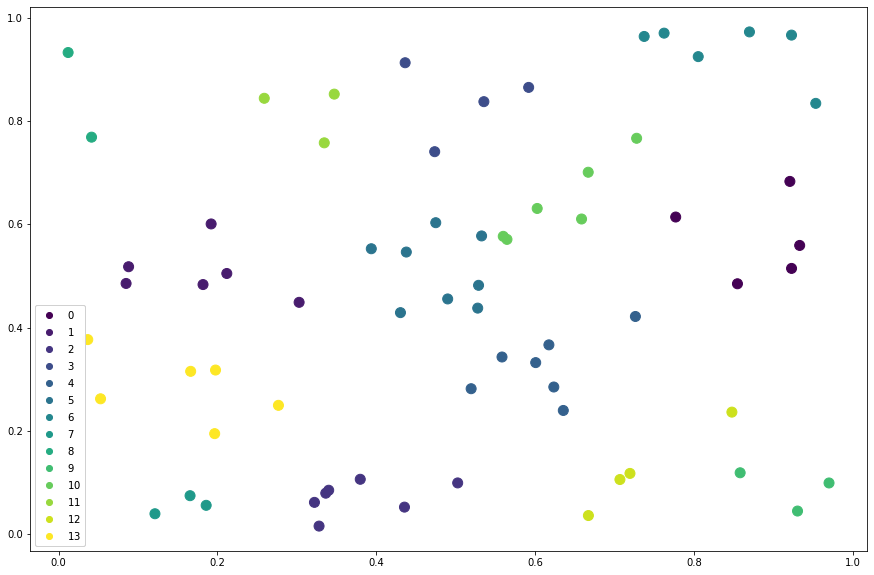

In [83]:
# Do optimized run
best_iteration = np.argmax(np.array(min_differences))
#best_iteration = np.argmin(np.array(variances))
X_train = np.array(schools[['x_location', 'y_location']])
labels = [i for i in range((DatasetSampler.n_schools // school_per_cluster))]
kmeans = KMeans(n_clusters=(DatasetSampler.n_schools // school_per_cluster), random_state=best_iteration)
preds = kmeans.fit_predict(X_train, labels)
means = kmeans.cluster_centers_
schools['cluster'] = preds

#plt.figure(figsize=(15,10))
#plt.scatter(X_train[:, 0], X_train[:, 1], c=preds, cmap='rainbow',)
#plt.scatter(means[:, 0], means[:, 1], c=labels, linewidth=10., cmap='rainbow')
#plt.show()
fig, ax = plt.subplots(figsize=(15, 10))
scatter = ax.scatter(X_train[:, 0], X_train[:, 1], c=preds, s=100)
legend1 = ax.legend(*scatter.legend_elements())
ax.add_artist(legend1)
plt.show()

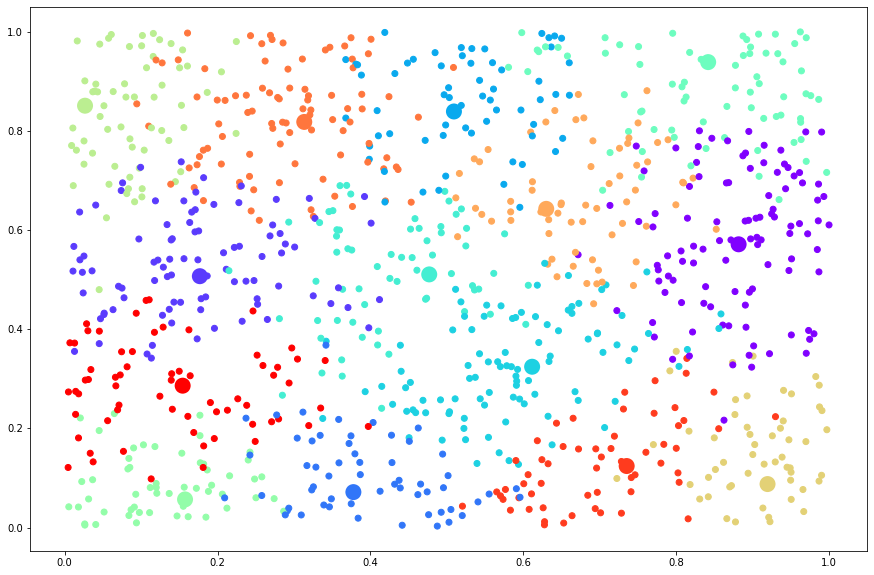

In [84]:
# KNN for Teacher-to-Cluster
knn = KNeighborsClassifier(n_neighbors=1, metric=custom_loss)
X_train = means
y_train = labels
knn.fit(X_train, y_train)
X_test = np.array(teachers[['x_location', 'y_location']])
preds = knn.predict(X_test + noise[i])
teachers['cluster'] = preds

plt.figure(figsize=(15,10))
plt.scatter(X_test[:, 0], X_test[:, 1], c=preds, cmap='rainbow')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, linewidth=10., cmap='rainbow')

In [85]:
# Fill DataFrame
cluster_df = pd.DataFrame({
                           'Cluster ID': labels,
                           'x_location': means[:, 0],
                           'y_location': means[:, 1],
                           'teacher_demand': schools.groupby(by='cluster')['n_teachers'].sum(),
                           'teacher_supply': teachers.groupby(by='cluster')['x_location'].count(),
                           })
cluster_df['teachers_difference'] = cluster_df['teacher_supply'] - cluster_df['teacher_demand']
cluster_df['teachers_difference_pct'] = cluster_df['teachers_difference'] / cluster_df['teacher_demand']

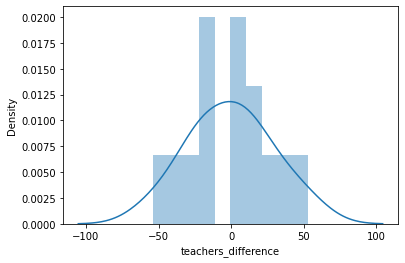

In [86]:
# Absolute Difference
sns.distplot(cluster_df['teachers_difference'], bins=10)

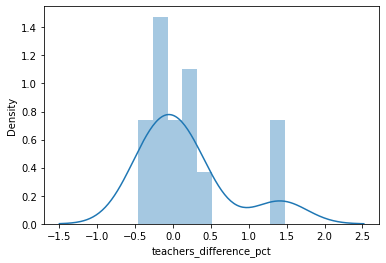

In [87]:
# Relative difference
sns.distplot(cluster_df['teachers_difference_pct'], bins=10)

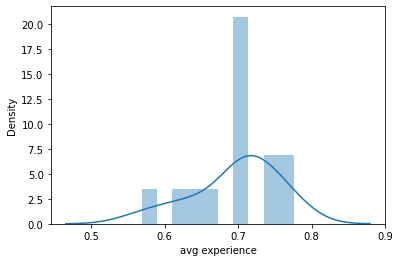

In [88]:
# Get avg experience (is center around 0.7 see class)
cluster_df['avg experience'] = teachers.groupby(by='cluster')['experience'].mean()
sns.distplot(cluster_df['avg experience'], bins=10)

In [89]:
teachers_for_pool = np.array(((cluster_df['teachers_difference_pct'] - (-0.2)) * cluster_df['teacher_demand'])).astype(int)
cluster_df['teachers_for_pool'] = np.clip(teachers_for_pool, a_min=0, a_max=None, out=teachers_for_pool)
cluster_df.head()

,Cluster ID,x_location,y_location,teacher_demand,teacher_supply,teachers_difference,teachers_difference_pct,avg experience,teachers_for_pool
cluster,,,,,,,,,
0,0,0.881479,0.571256,77,104,27,0.350649,0.711538,42
1,1,0.176910,0.506987,77,91,14,0.181818,0.703297,29
2,2,0.377684,0.071720,92,57,-35,-0.380435,0.736842,0
3,3,0.509187,0.839002,60,63,3,0.050000,0.634921,15
4,4,0.611436,0.324451,112,97,-15,-0.133929,0.711340,7


In [90]:
# Fix undersupplied clusters
clusters_undersupplied = cluster_df[cluster_df['teachers_difference_pct'] < -0.2]['Cluster ID']
cluster_pool = cluster_df[cluster_df['teachers_difference_pct'] >= -0.2]
cluster_pool_IDs = cluster_pool['Cluster ID']
cluster_pool_x_loc = cluster_pool['x_location']
cluster_pool_y_loc = cluster_pool['y_location']

# Make Reallocation Table
df_reallocation = pd.DataFrame()
for cluster in cluster_pool['Cluster ID']:
    df_reallocation[cluster] = np.zeros(len(clusters_undersupplied)).astype(int)
df_reallocation.set_index(clusters_undersupplied, inplace=True, drop=True)

for ID in clusters_undersupplied:
    cluster_ID = cluster_df['Cluster ID'][ID]
    cluster_x_loc = cluster_df['x_location'][ID]
    cluster_y_loc = cluster_df['y_location'][ID]
    cluster_supply = cluster_df['teacher_supply'][ID]
    cluster_demand = cluster_df['teacher_demand'][ID]
    cluster_optimal_demand = cluster_demand - cluster_supply
    cluster_minimum_demand = int(0.8 * cluster_demand - cluster_supply)
    
    # Get distances to other clusters oversupply of pool clusters
    distances_to_cluster_pool = np.sqrt((cluster_pool_x_loc - cluster_x_loc)**2 + 
                                        (cluster_pool_y_loc - cluster_y_loc)**2)
    sorted_distances = sorted(distances_to_cluster_pool)
    sorted_cluster_pool_IDs = [x for _, x in sorted(zip(distances_to_cluster_pool, cluster_pool_IDs))]
    teachers_oversupply_per_cluster = cluster_pool['teachers_for_pool']
    
    # Reallocate
    for cluster_pool_ID in sorted_cluster_pool_IDs:
        n_allocations = np.clip(cluster_minimum_demand, a_min=None, a_max=teachers_oversupply_per_cluster[cluster_pool_ID])
        cluster_minimum_demand -= n_allocations
        teachers_oversupply_per_cluster[cluster_pool_ID] -= n_allocations
        df_reallocation.loc[[ID], [cluster_pool_ID]] = n_allocations
        
        if cluster_minimum_demand == 0:
            break

In [91]:
for cluster_ID in cluster_pool_IDs:
    teacher_IDs = teachers[teachers['cluster'] == cluster_ID]['ID']
    n_allocations_from_cluster = df_reallocation[cluster_ID].sum()
    teachers_allocated_from_cluster = np.random.choice(teacher_IDs, n_allocations_from_cluster, replace=False)
    for ID in clusters_undersupplied:
        n_allocations_to_cluster = np.array(df_reallocation.loc[[ID], [cluster_ID]])[0][0]
        teachers_allocated_to_cluster = teachers_allocated_from_cluster[:n_allocations_to_cluster]
        teachers_allocated_from_cluster = teachers_allocated_from_cluster[n_allocations_to_cluster:]
        teachers['cluster'] = np.where(teachers['ID'].isin(teachers_allocated_to_cluster), ID, teachers['cluster'])

In [92]:
# Fill DataFrame
cluster_df = pd.DataFrame({
                           'Cluster ID': labels,
                           'x_location': means[:, 0],
                           'y_location': means[:, 1],
                           'teacher_demand': schools.groupby(by='cluster')['n_teachers'].sum(),
                           'teacher_supply': teachers.groupby(by='cluster')['x_location'].count(),
                           })
cluster_df['teachers_difference'] = cluster_df['teacher_supply'] - cluster_df['teacher_demand']
cluster_df['teachers_difference_pct'] = cluster_df['teachers_difference'] / cluster_df['teacher_demand']

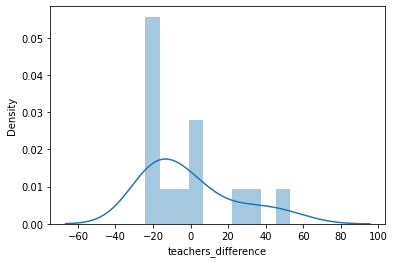

In [93]:
# Absolute Difference
sns.distplot(cluster_df['teachers_difference'], bins=10)

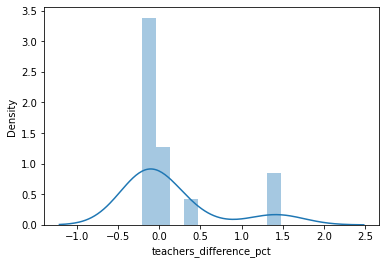

In [94]:
# Relative difference
sns.distplot(cluster_df['teachers_difference_pct'], bins=10)

In [95]:
teachers_from_pool = np.array(((0.2 - cluster_df['teachers_difference_pct']) * cluster_df['teacher_demand'])).astype(int)
cluster_df['teachers_from_pool'] = np.clip(teachers_from_pool, a_min=0, a_max=None, out=teachers_from_pool)
cluster_df.head(15)

,Cluster ID,x_location,y_location,teacher_demand,teacher_supply,teachers_difference,teachers_difference_pct,teachers_from_pool
cluster,,,,,,,,
0,0,0.881479,0.571256,77,104,27,0.350649,0
1,1,0.176910,0.506987,77,65,-12,-0.155844,27
2,2,0.377684,0.071720,92,73,-19,-0.206522,37
3,3,0.509187,0.839002,60,60,0,0.000000,12
4,4,0.611436,0.324451,112,90,-22,-0.196429,44
5,5,0.476871,0.510596,118,94,-24,-0.203390,47
6,6,0.841649,0.938550,96,76,-20,-0.208333,39
7,7,0.157527,0.057014,42,38,-4,-0.095238,12
8,8,0.026750,0.850657,25,62,37,1.480000,0


In [96]:
# Fix oversupplied clusters
clusters_oversupplied = cluster_df[cluster_df['teachers_difference_pct'] > 0.2]['Cluster ID']
cluster_pool = cluster_df[cluster_df['teachers_difference_pct'] <= 0.2]
cluster_pool_IDs = cluster_pool['Cluster ID']
cluster_pool_x_loc = cluster_pool['x_location']
cluster_pool_y_loc = cluster_pool['y_location']

# Make Reallocation Table
df_reallocation = pd.DataFrame()
for cluster in clusters_oversupplied:
    df_reallocation[cluster] = np.zeros(len(cluster_pool_IDs)).astype(int)
df_reallocation.set_index(cluster_pool_IDs, inplace=True, drop=True)
df_reallocation.head(10)

,0,8,11
Cluster ID,,,
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
5,0,0,0
6,0,0,0
7,0,0,0
9,0,0,0
10,0,0,0


In [101]:
for ID in clusters_oversupplied:
    cluster_ID = cluster_df['Cluster ID'][ID]
    cluster_x_loc = cluster_df['x_location'][ID]
    cluster_y_loc = cluster_df['y_location'][ID]
    cluster_supply = cluster_df['teacher_supply'][ID]
    cluster_demand = cluster_df['teacher_demand'][ID]
    cluster_optimal_supply = cluster_supply - cluster_demand
    cluster_minimum_supply = int(cluster_supply - 1.2 * cluster_demand)
    
    # Get distances to other clusters oversupply of pool clusters
    distances_to_cluster_pool = np.sqrt((cluster_pool_x_loc - cluster_x_loc)**2 + 
                                        (cluster_pool_y_loc - cluster_y_loc)**2)
    sorted_distances = sorted(distances_to_cluster_pool)
    sorted_cluster_pool_IDs = [x for _, x in sorted(zip(distances_to_cluster_pool, cluster_pool_IDs))]
    teachers_undersupply_per_cluster = cluster_pool['teachers_from_pool']
    
    # Reallocate
    for cluster_pool_ID in sorted_cluster_pool_IDs:
        n_allocations = np.clip(cluster_minimum_supply, a_min=None, a_max=teachers_undersupply_per_cluster[cluster_pool_ID])
        cluster_minimum_supply -= n_allocations
        teachers_undersupply_per_cluster[cluster_pool_ID] -= n_allocations
        df_reallocation.loc[[cluster_pool_ID], [ID]] = n_allocations
        
        if cluster_minimum_supply == 0:
            break

0
11
0
0
32
0
0
15
0
30


In [103]:
for cluster_ID in clusters_oversupplied:
    teacher_IDs = teachers[teachers['cluster'] == cluster_ID]['ID']
    n_allocations_from_cluster = df_reallocation[cluster_ID].sum()
    teachers_allocated_from_cluster = np.random.choice(teacher_IDs, n_allocations_from_cluster, replace=False)
    for ID in cluster_pool_IDs:
        n_allocations_to_cluster = np.array(df_reallocation.loc[[ID], [cluster_ID]])[0][0]
        teachers_allocated_to_cluster = teachers_allocated_from_cluster[:n_allocations_to_cluster]
        teachers_allocated_from_cluster = teachers_allocated_from_cluster[n_allocations_to_cluster:]
        teachers['cluster'] = np.where(teachers['ID'].isin(teachers_allocated_to_cluster), ID, teachers['cluster'])

In [104]:
# Fill DataFrame
cluster_df = pd.DataFrame({
                           'Cluster ID': labels,
                           'x_location': means[:, 0],
                           'y_location': means[:, 1],
                           'teacher_demand': schools.groupby(by='cluster')['n_teachers'].sum(),
                           'teacher_supply': teachers.groupby(by='cluster')['x_location'].count(),
                           })
cluster_df['teachers_difference'] = cluster_df['teacher_supply'] - cluster_df['teacher_demand']
cluster_df['teachers_difference_pct'] = cluster_df['teachers_difference'] / cluster_df['teacher_demand']

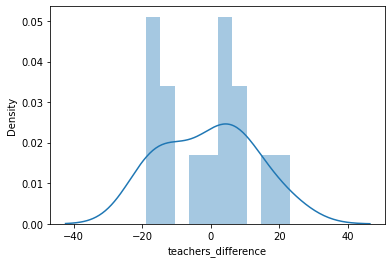

In [105]:
# Absolute Difference
sns.distplot(cluster_df['teachers_difference'], bins=10)

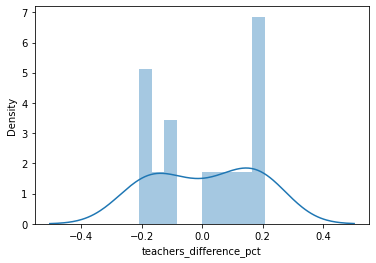

In [106]:
# Relative difference
sns.distplot(cluster_df['teachers_difference_pct'], bins=10)

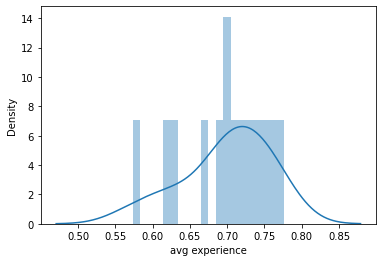

In [113]:
# Get avg experience (is center around 0.7 see class)
cluster_df['avg experience'] = teachers.groupby(by='cluster')['experience'].mean()
sns.distplot(cluster_df['avg experience'], bins=20)